# Toy Example - GMM WBT and DaDiL

In this notebook, we detail the implementation and main concepts of our paper ["Lighter, Better, Faster Multi-Source Domain Adaptation with Gaussian Mixture Models and Optimal Transport"](https://arxiv.org/abs/2404.10261). Here, we will cover our two methods: GMM-Wasserstein Barycenter Transport and GMM-Dataset Dictionary Learning, which are based on our developments on the theory of Gaussian Mixture Model-based Optimal Transport.

Here are some useful papers and links to get some background on our paper,

- Optimal transport between Gaussian Mixture Models [[Delon and Desolneux, 2020]](https://arxiv.org/abs/1907.05254), [[Code]](https://github.com/judelo/gmmot)
- Dataset Dictionary Learning [[Montesuma, Mboula and Souloumiac, 2023]](https://arxiv.org/abs/2307.14953), [[Code]](https://github.com/eddardd/demo-dadil)
- Wasserstein Barycenter Transport [[Montesuma and Mboula, 2021]](https://openaccess.thecvf.com/content/CVPR2021/papers/Montesuma_Wasserstein_Barycenter_for_Multi-Source_Domain_Adaptation_CVPR_2021_paper.pdf), [[Code]](https://github.com/eddardd/WBTransport)

In [1]:
import ot
import math
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from matplotlib.patches import ConnectionPatch

2024-06-02 21:46:11.053587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 21:46:11.140175: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 21:46:11.143093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/efernand/anaconda3/envs/OptimalTransport/lib/
2024-06-02 21:46:11.143103: I tensorflow/stream_executo

# Auxiliar Code

In this section of the notebook, we define a few useful functions.

## Toy Example

The following functions create the toy example we use in section 4.1. First, we use a function for creating a classification dataset where the two classes are Gaussian measures with the same covariance. We use a random separation vector, so that the mean vector of the first class is $\mu$, and the mean vector of the second class is $\mu + separation \times \dfrac{\mathbf{v}}{|| \mathbf{v} ||_{2}}$, where $\mathbf{v} \sim \mathcal{N}(0, \mathbf{Id}_{2})$. We control the degree of separation of the two blobs with separation, and the values of the covariance matrix $\Sigma$. For data with higher variance, one might need a higher separation parameter.

In [2]:
def make_classification_dataset(mean,
                                cov,
                                v=None,
                                separation=1,
                                n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

the next function effectively creates the adaptation problem. We gradually rotate the frontiers of the datasets from an initial angle $\theta_{0}$ towards a max angle $\theta_{1}$. The interval $[\theta_{0}, \theta_{1}]$ is divded by the number of desired domains.

In [3]:
def msda_toy_example(n_datasets,
                     n_samples=400,
                     angle_min=0.0,
                     angle_max=45,
                     separation=6):
    mu = np.array([0, 0])
    angles = np.linspace(angle_min, angle_max, n_datasets)
    Xs, Ys = [], []
    for i in range(n_datasets - 1):
        A = np.random.randn(2, 2)
        cov = .25 * np.dot(A.T, A) + np.eye(2)
        v = np.array([np.cos((np.pi / 180) * angles[i]),
                      np.sin((np.pi / 180) * angles[i])])
        X, y = make_classification_dataset(mu, cov, v=v,
                                           separation=separation,
                                           n=n_samples)

        Xs.append(torch.from_numpy(X).float())
        Ys.append(
            torch.nn.functional.one_hot(torch.from_numpy(y).long(),
                                        num_classes=2).float())

    A = np.random.randn(2, 2)
    cov = .1 * np.dot(A.T, A) + np.eye(2)
    v = np.array([np.cos((np.pi / 180) * angles[-1]),
                  np.sin((np.pi / 180) * angles[-1])])
    Xt, yt = make_classification_dataset(mu, cov,
                                         v=v,
                                         separation=separation,
                                         n=n_samples)
    Xt = torch.from_numpy(Xt).float()
    Yt = torch.nn.functional.one_hot(
        torch.from_numpy(yt).long(), num_classes=2).float()

    return Xs, Ys, Xt, Yt

## Visualization

Here's a simple function for visualizing the covariance matrix of the GMM.

[[Source]](https://github.com/skolouri/swgmm)

In [6]:
def plot_cov_ellipse(pos, cov, nstd=2, ax=None, c='k', alpha=1.0, zorder=1):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos,
                    width=width,
                    height=height,
                    angle=theta,
                    facecolor='none',
                    edgecolor=c,
                    linewidth=2,
                    zorder=zorder,
                    alpha=alpha)

    ax.add_artist(ellip)
    return ax

## GMMs

Here we define some functions for dealing with GMMs. The first concerns the log of the probabilities $P_{\theta}(\mathbf{x})$.

__Important.__ Throughout our paper, we assume axis-aligned covariance matrices. This choice helps us avoid matrix inversions and computing square roots of matrices, thus enhancing numerical stability.

For efficiency purposes, we implement in the next function the innermost part of the following equation,

$$\log P_{\theta}(\mathbf{x}) = \log \sum_{k=1}^{K}p_{k}\mathcal{N}(\mathbf{x}|\mu_{k}^{(P)},\sigma_{k}^{(P)}) = \log \sum_{k=1}^{K} e^{\log p_{k} + \log \mathcal{N}(\mathbf{x}|\mu_{k}^{(P)},\sigma_{k}^{(P)})}$$

so that, in order to retrieve $P_{\theta}(\mathbf{x})$, we apply [log-sum-exp](https://pytorch.org/docs/stable/generated/torch.logsumexp.html) to the return value ```log_probs```

In [4]:
def diag_gmm_log_probs(X, weights, means, stds):
    n_dim = X.shape[1]
    log_probs = (torch.log(weights)[:, None] - 0.5 * (
        n_dim * math.log(2 * math.pi) +
        2 * torch.log(stds).sum(dim=1)[:, None] + (
            (1 / stds ** 2) @ X.T ** 2 +
            torch.sum((means / stds) ** 2, 1)[:, None] -
            2 * ((means / (stds ** 2)) @ X.T)
        )
    ))

    return log_probs

Next, as we describe in the section 3.2 of our paper, we create labeled GMMs by fitting a GMM to the conditional probability measure $P(X|Y)$. Naturally, the GMM fitted to a given $P(X|Y=y)$ inherits the hard label $y$ from the data it was fitted. Here's the code to do so,

In [5]:
def em_conditional_gmm(Xs, Ys,
                       clusters_per_class,
                       n_classes,
                       dtype=torch.float32,
                       **kwargs):
    n_clusters = clusters_per_class * n_classes

    means = []
    labels = []
    weights = []
    variances = []
    for Xsk, Ysk in zip(Xs, Ys):
        _labels = []
        _weights = []
        _means = []
        _variances = []
        for c in Ysk.argmax(dim=1).unique():
            ind = torch.where(Ysk.argmax(dim=1) == c)
            
            # Fit GMM on data conditioned on the class
            gmm = GaussianMixture(
                n_components=clusters_per_class,
                covariance_type='diag',
                **kwargs
            ).fit(Xsk[ind])
            
            # Gets parameters of GMMs
            w = torch.from_numpy(gmm.weights_).to(dtype)
            m = torch.from_numpy(gmm.means_).to(dtype)
            v = torch.from_numpy(gmm.covariances_).to(dtype)

            # Appends overall parameters
            _weights.append(w)
            _means.append(m)
            _variances.append(v)
            
            # GMM labels are inherited from data
            _labels.append(
                torch.nn.functional.one_hot(
                    torch.Tensor([c] * len(m)).long(),
                    num_classes=n_classes
                ).to(dtype)
            )
        
        # Weights are renormalized
        _weights = torch.cat(_weights, dim=0)
        weights.append(_weights / _weights.sum())
        
        # Other parameters are simply concatenated
        means.append(torch.cat(_means, dim=0))
        labels.append(torch.cat(_labels, dim=0))
        variances.append(torch.cat(_variances, dim=0))

    return [
        (wk, mk, vk, yk) for wk, mk, vk, yk in zip(
            weights, means, variances, labels
        )
    ]

## Optimal Transport

In this section we define a few functions for performing GMM-OT and computing the $\mathcal{SMW}_{2}$ distance. The next two functions are simply utilities to adapt some POT functions to pytorch. Aparently, the ```proj_simplex``` function of POT does not work well with tensors. Below I define a quick fix for it.

In [7]:
def unif(n, device='cpu', dtype=torch.float32):
    return torch.ones(n, device=device, dtype=dtype) / n

In [8]:
def proj_simplex(v, z=1):
    r"""Re-implements ot.utils.proj_simplex using torch.
    This was necessary due to strange behavior of POT w.r.t. GPU memory."""
    n = v.shape[0]
    if v.ndim == 1:
        d1 = 1
        v = v[:, None]
    else:
        d1 = 0
    d = v.shape[1]

    # sort u in ascending order
    u, _ = torch.sort(v, dim=0)
    # take the descending order
    u = torch.flip(u, dims=[0])
    cssv = torch.cumsum(u, dim=0) - z
    ind = torch.arange(n, dtype=v.dtype)[:, None] + 1
    cond = u - cssv / ind > 0
    rho = torch.sum(cond, 0)
    theta = cssv[rho - 1, torch.arange(d)] / rho
    w = torch.maximum(v - theta[None, :], torch.zeros(v.shape, dtype=v.dtype))
    if d1:
        return w[:, 0]
    else:
        return w

In our paper, we define the $\mathcal{SMW}_{2}$ as,

$$\mathcal{SMW}_{2}(P, Q)^{2} = \underset{\omega \in \Gamma(\mathbf{p},\mathbf{q})}{\text{min}}\sum_{i=1}^{K_{P}}\sum_{j=1}^{K_{Q}}\omega_{ij}(\mathcal{W}_{2}(P_{i},Q_{j})^{2} + \beta\lVert \mathbf{v}_{i}^{(P)} - \mathbf{v}_{j}^{(Q)} \rVert_{2}^{2})$$

where $\omega$ is a transport plan __between components__ of $P$ and $Q$. As we comment on our paper, we bypass the linear programming layer (i.e., $\text{min}_{\omega}$) by invoking the "Envelope Theorem" (a brief description can be found at [wikipedia](https://en.wikipedia.org/wiki/Envelope_theorem), otherwise we provide a reference for the theorem in our main paper).

In [9]:
class JointMixtureWassersteinDistance(torch.nn.Module):
    def __init__(self):
        super(JointMixtureWassersteinDistance, self).__init__()

    def forward(self,
                source_means,
                source_variances,
                source_labels,
                target_means,
                target_variances,
                target_labels,
                source_weights=None,
                target_weights=None):
        if source_weights is None:
            source_weights = torch.ones(len(source_means)) / len(source_means)
        if target_weights is None:
            target_weights = torch.ones(len(target_means)) / len(target_means)
        C_means = torch.cdist(source_means,
                              target_means, p=2) ** 2
        C_stds = torch.cdist(torch.sqrt(source_variances),
                             torch.sqrt(target_variances), p=2) ** 2
        beta = (C_means + C_stds).detach().max()
            
        if ((source_labels is not None) and
            (target_labels is not None)):
            C_labels = torch.cdist(source_labels, target_labels, p=2) ** 2
        else:
            C_labels = torch.zeros_like(C_means)
        ot_plan = ot.emd(source_weights,
                         target_weights,
                         C_means + C_stds + beta * C_labels)
        loss = torch.sum(ot_plan * (C_means + C_stds + beta * C_labels))
        return loss

Here, we lay out the algorithm for computing $\mathcal{SMW}_{2}$ barycenters, which we defined in our main paper as the measure $B^{\star}$ that minimizes,

$$B^{\star} = \mathcal{B}(\lambda,\mathcal{P}) = \underset{B \in \text{GMM}_{d}(K_{B})}{\text{argmin}}\biggr{\{}\mathcal{L}(B) = \sum_{c=1}^{C}\lambda_{c}\mathcal{SMW}_{2}(B,P_{c})^{2}\biggr{\}}.$$

In practice, this minimization is carried out with respect $\theta_{B} = \{(\mathbf{m}_{i}^{(B)}, \mathbf{s}_{i}^{(B)},\mathbf{v}_{i}^{(B)})\}_{i=1}^{K_{B}}$. Here, you may find the actual implementation of Algorithm 1 in our main paper,

In [10]:
def mixture_wasserstein_barycenter(
        source_means,
        source_variances,
        source_labels=None,
        barycenter_means=None,
        barycenter_variances=None,
        barycenter_labels=None,
        n_clusters=None,
        weights=None,
        n_iter_max=100,
        tol=1e-4,
        verbose=False,
        inner_verbose=False,
        propagate_labels=False,
        penalize_labels=False,
        log=False):
    if source_labels is None:
        if propagate_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                             " for 'propagate_labels' = True"))
        if penalize_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                              " for 'penalize_labels' = True"))
    dtype = source_means[0].dtype
    device = source_means[0].device
    n_dim = source_means[0].shape[1]
    n_measures = len(source_means)

    if n_clusters is None:
        n_clusters = source_means[0].shape[0]

    if weights is None:
        weights = unif(n_measures, device=device, dtype=dtype)

    it = 0
    comp_start = time.time()

    if barycenter_means is None:
        barycenter_means = torch.zeros(n_clusters, n_dim, dtype=dtype).to(device)

    if barycenter_variances is None:
        barycenter_variances = torch.ones(n_clusters, n_dim, dtype=dtype).to(device)

    if source_labels is not None and barycenter_labels is None:
        n_classes = source_labels[0].shape[1]
        n_elems = n_clusters // n_classes
        barycenter_labels = torch.nn.functional.one_hot(
            torch.Tensor(
                [i for i in range(n_classes)] * n_elems).long(),
            num_classes=n_classes).to(dtype).to(device)

    # Displacement of points in the support
    delta = tol + 1
    last_loss = np.inf

    # Create uniform weights
    u_P = [unif(len(MP_k), device=device) for MP_k in source_means]
    u_B = unif(n_clusters, device=device)

    if verbose:
        print("-" * (26 * 4 + 1))
        print("|{:^25}|{:^25}|{:^25}|{:^25}|".format('Iteration',
                                                     'Loss',
                                                     'δLoss',
                                                     'Elapsed Time'))
        print("-" * (26 * 4 + 1))

    if log:
        extra_ret = {'transport_plans': [], 'd_loss': [], 'loss_hist': []}

    while (delta > tol and it < n_iter_max):
        # NOTE: Here we solve the barycenter problem without calculating
        # gradients at each iteration, as per the envelope theorem, we
        # only need to compute gradients at optimality.
        with torch.no_grad():
            tstart = time.time()
            C, ot_plans = [], []

            # Solve OT problems
            for k in range(n_measures):
                C_k = (torch.cdist(source_means[k],
                                   barycenter_means, p=2) ** 2 +
                       torch.cdist(torch.sqrt(source_variances[k]),
                                   torch.sqrt(barycenter_variances), p=2) ** 2)
                _lw = C_k.max().detach()
                if penalize_labels:
                    C_k = C_k + _lw * torch.cdist(source_labels[k],
                                                  barycenter_labels, p=2) ** 2
                C.append(C_k)
                
                plan_k = ot.emd(u_P[k], u_B, C_k)
                ot_plans.append(plan_k.to(dtype))
            
            # Update barycenter parameters
            barycenter_means = sum([
                w_k * n_clusters * torch.mm(plan_k.T, MP_k)
                for w_k, plan_k, MP_k in zip(weights, ot_plans, source_means)
            ])
            barycenter_variances = sum([
                w_k * n_clusters * torch.mm(plan_k.T, torch.sqrt(VP_k))
                for w_k, plan_k, VP_k in zip(weights, ot_plans, source_variances)
            ]) ** 2
            if propagate_labels:
                barycenter_labels = sum([
                    w_k * n_clusters * torch.mm(plan_k.T, YP_k)
                    for w_k, plan_k, YP_k in zip(weights, ot_plans, source_labels)
                ])
                
            # Computes loss
            loss = sum([
                torch.sum(C_k * plan_k) for C_k, plan_k in zip(C, ot_plans)
            ])
            delta = torch.norm(loss - last_loss) / n_clusters
            last_loss = loss
            tfinish = time.time()

            if verbose:
                delta_t = tfinish - tstart
                print("|{:^25}|{:^25}|{:^25}|{:^25}|".format(it,
                                                             loss,
                                                             delta,
                                                             delta_t))

            if log:
                extra_ret['loss_hist'].append(loss)
                extra_ret['d_loss'].append(delta)

            it += 1
    if verbose:
        duration = time.time() - comp_start
        print("-" * (26 * 4 + 1))
        print(f"Barycenter calculation took {duration} seconds")
    
    # Re-evaluate the support at optimality for calculating the gradients
    # NOTE: now we define the support while holding its gradients w.r.t. the
    # weight vector and eventually the support.
    barycenter_means = sum([
        w_k * n_clusters * torch.mm(plan_k.T, MP_k)
        for w_k, plan_k, MP_k in zip(weights, ot_plans, source_means)
    ])
    barycenter_variances = sum([
        w_k * n_clusters * torch.mm(plan_k.T, torch.sqrt(VP_k))
        for w_k, plan_k, VP_k in zip(weights, ot_plans, source_variances)
    ]) ** 2
    if propagate_labels:
        barycenter_labels = sum([
            w_k * n_clusters * torch.mm(plan_k.T, YP_k)
            for w_k, plan_k, YP_k in zip(weights, ot_plans, source_labels)
        ])
        if log:
            extra_ret['transport_plans'] = ot_plans
            return (barycenter_means,
                    barycenter_variances,
                    barycenter_labels, extra_ret)
        return (barycenter_means,
                barycenter_variances,
                barycenter_labels)
    if log:
        extra_ret['transport_plans'] = ot_plans
        return (barycenter_means,
                barycenter_variances,
                extra_ret)
    return (barycenter_means,
            barycenter_variances)

# Toy Example

Here, we create the toy dataset. Our toy example uses $d = 2$, $n_{c} = 2$. We learn, on each domain, a GMM comprised of $2 \times 10$ components. Here, note that the ```clusters_per_class``` controls the number of components on each class. We have 4 datasets, that have a rotation parameter ranging from $\theta_{0} = 0$ to $\theta_{1} = 30$. We sample $n = 500$ points from each domain.

In [11]:
n_dim = 2
n_classes = 2
n_components = 3
n_clusters = 10
clusters_per_class = n_clusters // n_classes
n_datasets = 4
n_samples = 500
angle_min = 0
angle_max = 30

In [12]:
Xs, Ys, Xt, Yt = msda_toy_example(
    n_datasets,
    n_samples=n_samples,
    angle_min=angle_min,
    angle_max=angle_max,
    separation=10)

In [13]:
true_features = Xs + [Xt,]
true_labels = Ys + [Yt,]

In [14]:
xmin, xmax = torch.cat(true_features, dim=0)[:, 0].min(), torch.cat(true_features, dim=0)[:, 0].max()
ymin, ymax = torch.cat(true_features, dim=0)[:, 1].min(), torch.cat(true_features, dim=0)[:, 1].max()
print(xmin, xmax, ymin, ymax)

tensor(-5.2431) tensor(13.2175) tensor(-4.4330) tensor(7.7769)


Here, we visualize the points for each domain (Fig. 3 (a)).

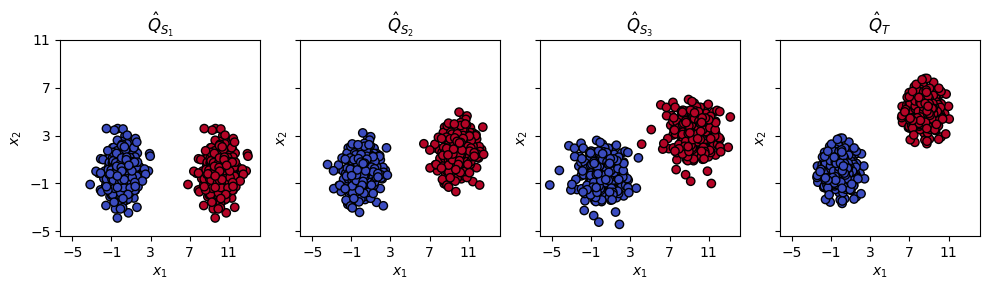

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(true_features[:-1], true_labels[:-1], axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xticks([-5, -1, 3, 7, 11])
    ax.set_yticks([-5, -1, 3, 7, 11])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

ax = axes.flatten()[-1]
Xi = true_features[-1]
Yi = true_labels[-1]
ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")

ax.set_xlabel(r'$x_{1}$')
ax.set_ylabel(r'$x_{2}$')

plt.tight_layout()

Now, we learn a GMM on each domain (sources use labels, while target does a classic Expectation Maximization algorithm).

In [16]:
source_gmms = em_conditional_gmm(Xs, Ys, clusters_per_class, n_classes, dtype=torch.float64,
                                 random_state=42)

In [17]:
gmm_T = GaussianMixture(n_components=clusters_per_class * n_classes,
                        covariance_type='diag',
                        random_state=42).fit(Xt)

target_gmm = [(
    torch.from_numpy(gmm_T.weights_).double(),
    torch.from_numpy(gmm_T.means_).double(),
    torch.from_numpy(gmm_T.covariances_).double(),
    None
),]

In [18]:
gmms = source_gmms + target_gmm

We can visualize the learned GMMs as we did before (Fig. 3 (b) in the main paper).

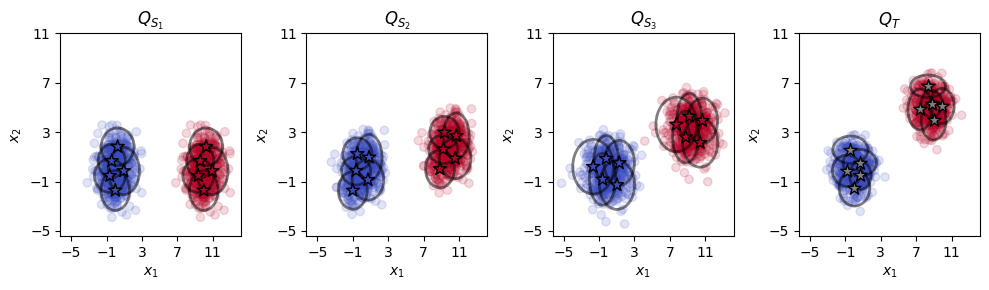

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))

for i, (ax, Xi, Yi, (W, CX, U, CY)) in enumerate(
        zip(axes.flatten(), true_features, true_labels, gmms)
    ):
    ax.scatter(x=Xi[:, 0], y=Xi[:, 1], c=Yi[:, 1], cmap='coolwarm', alpha=0.15, zorder=1)
    if CY is not None:
        ax.scatter(CX[:, 0], CX[:, 1], marker='*', edgecolor='k', s=100, c=CY[:, 1], cmap='coolwarm', zorder=5)
        ax.set_title(r"$Q_{S_{" + str(i + 1) + "}}$")
    else:
        ax.scatter(CX[:, 0], CX[:, 1], marker='*', edgecolor='k', s=100, zorder=5, color='gray')
        ax.set_title(r"$Q_{T}$")
    for c, u in zip(CX, U):
        plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax, zorder=1, alpha=0.5)

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xticks([-5, -1, 3, 7, 11])
    ax.set_yticks([-5, -1, 3, 7, 11])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')
plt.tight_layout()

## GMM-WBT

For GMM-WBT, we adopt a 2 steps approach similar to WBT. First, we calculate a GMM-Barycenter of source domains,

$$\hat{B} = \mathcal{B}(\mathbf{1}_{N} / N, \mathcal{Q}_{S})$$

In [20]:
barycenter_means, barycenter_variances, barycenter_labels = mixture_wasserstein_barycenter(
    source_means=[gmm[1] for gmm in gmms[:-1]],
    source_variances=[gmm[2] for gmm in gmms[:-1]],
    source_labels=[gmm[3] for gmm in gmms[:-1]],
    n_clusters=None,
    weights=None,
    n_iter_max=100,
    tol=1e-9,
    verbose=True,
    inner_verbose=False,
    propagate_labels=True,
    penalize_labels=True,
    log=False)

---------------------------------------------------------------------------------------------------------
|        Iteration        |          Loss           |          δLoss          |      Elapsed Time       |
---------------------------------------------------------------------------------------------------------
|            0            |    153.8735564594153    |           inf           |   0.06822991371154785   |
|            1            |    4.718612227121042    |   14.915494423229427    |  0.0008084774017333984  |
|            2            |   4.1313456480361985    |   0.05872665790848437   |  0.0007619857788085938  |
|            3            |   4.1313456480361985    |           0.0           |  0.0010776519775390625  |
---------------------------------------------------------------------------------------------------------
Barycenter calculation took 0.07151532173156738 seconds


In [21]:
target_weights, target_means, target_variances, _ = gmms[-1]

Now, since each $Q \in \mathcal{Q}_{S}$ is labeled, the barycenter $\hat{B}$ is labeled as well. Our next step consists of solving,

$$\omega^{(T)} = \underset{\omega \in \Gamma(P, Q)}{\text{argmin}}\sum_{i=1}^{K_{B}}\sum_{j=1}^{K_{T}}\omega_{ij}\mathcal{W}_{2}(B_{i},Q_{T,j})^{2}$$

In [22]:
a = torch.ones(n_clusters) / n_clusters
b = target_weights
C = (torch.cdist(barycenter_means, target_means, p=2) ** 2 +
     torch.cdist(barycenter_variances, target_variances, p=2) ** 2)
ot_plan = ot.emd(a, b, C)
ind_i, ind_j = torch.where(ot_plan > 0.0)

We can then transport the parameters of the barycenter GMM to the target domain,

$$\hat{\mathbf{m}}_{i}^{(Q_{T})} = K_{B}\sum_{j=1}^{K_{T}}\omega_{ij}^{(T)}\mathbf{m}_{j}^{(Q_{T})}\text{, and, }\hat{\mathbf{s}}_{i}^{(Q_{T})} = K_{B}\sum_{j=1}^{K_{T}}\omega_{ij}^{(T)}\mathbf{s}_{j}^{(Q_{T})}.$$

In [23]:
estim_target_means = torch.mm((ot_plan / ot_plan.sum(dim=1)[:, None]).double(),
                              target_means)
estim_target_variances = torch.mm((ot_plan / ot_plan.sum(dim=1)[:, None]).double(),
                                  torch.sqrt(target_variances)) ** 2

We can now visualize the resulting GMM $\{\hat{\mathbf{m}}_{i}^{(Q_{T})},\hat{\mathbf{s}}_{i}^{(Q_{T})},\hat{\mathbf{y}}_{i}^{(B)}\}_{i=1}^{K_{T}}$:

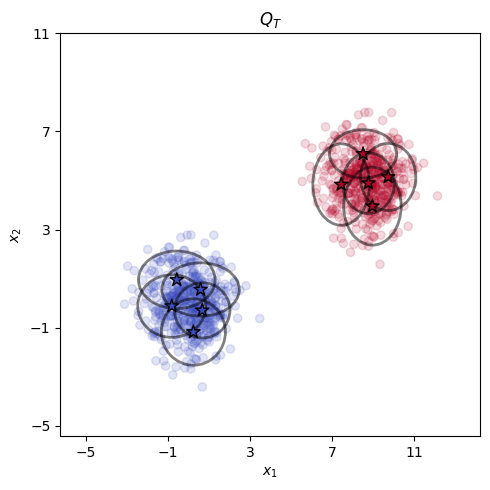

In [24]:
plt.figure(figsize=(5, 5))

plt.scatter(x=Xi[:, 0], y=Xi[:, 1], c=Yi[:, 1], cmap='coolwarm', alpha=0.15, zorder=1)
plt.scatter(estim_target_means[:, 0], estim_target_means[:, 1],
            marker='*', edgecolor='k', s=100,
            c=barycenter_labels[:, 1], cmap='coolwarm', zorder=5)
plt.title(r"$Q_{T}$")
for c, u in zip(estim_target_means, estim_target_variances):
    plot_cov_ellipse(pos=c, cov=np.diag(u), zorder=1, alpha=0.5)

plt.xlim([xmin - 1, xmax + 1])
plt.ylim([ymin - 1, ymax + 1])

plt.xticks([-5, -1, 3, 7, 11])
plt.yticks([-5, -1, 3, 7, 11])

plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')
plt.tight_layout()

and reproduce Fig. 3 (c),

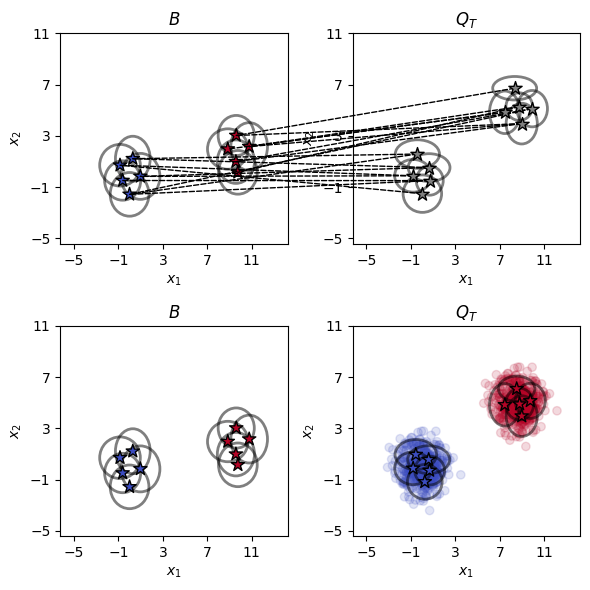

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

ax1, ax2 = axes[0, :]
ax3, ax4 = axes[1, :]

ax1.scatter(barycenter_means[:, 0],
            barycenter_means[:, 1],
            marker='*', edgecolor='k',
            s=100, c=barycenter_labels[:, 1], cmap='coolwarm', zorder=5)
for c, u in zip(barycenter_means, barycenter_variances):
    plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax1, zorder=1, alpha=0.5)

ax1.set_xlim([xmin - 1, xmax + 1])
ax1.set_ylim([ymin - 1, ymax + 1])

ax1.set_xticks([-5, -1, 3, 7, 11])
ax1.set_yticks([-5, -1, 3, 7, 11])

ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')

ax1.set_title("$B$")

ax3.scatter(barycenter_means[:, 0],
            barycenter_means[:, 1],
            marker='*', edgecolor='k',
            s=100, c=barycenter_labels[:, 1], cmap='coolwarm', zorder=5)
for c, u in zip(barycenter_means, barycenter_variances):
    plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax3, zorder=1, alpha=0.5)

ax3.set_xlim([xmin - 1, xmax + 1])
ax3.set_ylim([ymin - 1, ymax + 1])

ax3.set_xticks([-5, -1, 3, 7, 11])
ax3.set_yticks([-5, -1, 3, 7, 11])

ax3.set_xlabel(r'$x_{1}$')
ax3.set_ylabel(r'$x_{2}$')

ax3.set_title("$B$")

ax2.scatter(target_means[:, 0], target_means[:, 1],
            marker='*', edgecolor='k', s=100, c='gray', zorder=5)
for c, u in zip(target_means, target_variances):
    plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax2, zorder=1, alpha=0.5)

ax2.set_xlim([xmin - 1, xmax + 1])
ax2.set_ylim([ymin - 1, ymax + 1])

ax2.set_xticks([-5, -1, 3, 7, 11])
ax2.set_yticks([-5, -1, 3, 7, 11])

ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')

ax2.set_title("$Q_{T}$")

Xi, Yi = true_features[-1], true_labels[-1]
ax4.scatter(x=Xi[:, 0], y=Xi[:, 1], c=Yi[:, 1], cmap='coolwarm', alpha=0.15, zorder=1)
ax4.scatter(estim_target_means[:, 0], estim_target_means[:, 1],
            marker='*', edgecolor='k', s=100,
            c=barycenter_labels[:, 1], cmap='coolwarm', zorder=5)
for c, u in zip(estim_target_means, estim_target_variances):
    plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax4, zorder=1, alpha=0.5)

ax4.set_xlim([xmin - 1, xmax + 1])
ax4.set_ylim([ymin - 1, ymax + 1])
    
ax4.set_xticks([-5, -1, 3, 7, 11])
ax4.set_yticks([-5, -1, 3, 7, 11])

ax4.set_xlabel(r'$x_{1}$')
ax4.set_ylabel(r'$x_{2}$')

ax4.set_title("$Q_{T}$")

plt.tight_layout()

for i, j in zip(ind_i, ind_j):
    xyA = (target_means[i, 0], target_means[i, 1])
    xyB = (barycenter_means[j, 0], barycenter_means[j, 1])
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="k", linestyle='--', zorder=1,
                          alpha=(ot_plan[i, j] / ot_plan[i, j].max()).item())
    ax2.add_artist(con)

## GMM-DaDiL

Our second algorithm consists of a parametric version for the DaDiL algorithm. The idea is to replace the atoms in $\mathcal{P} = \{\hat{P}_{c}\}_{c=1}^{C}$ by \glspl{gmm} parametrized through $\Theta_{P} = \{(\mathbf{M}^{(P_{c})}, \mathbf{S}^{(P_{c})}, \mathbf{V}^{(P_{c})})\}_{c=1}^{C}$. Learning a dictionary is thus equivalent to estimating these parameters, that is,
$$
    (\Lambda^{\star}, \Theta_{P}^{\star}) = \underset{\Lambda,\Theta_{P}}{\text{argmin}} \mathcal{MW}_{2}(Q_{T}, \mathcal{B}(\lambda_{T};\mathcal{P}))^{2} + \sum_{\ell=1}^{N}\mathcal{SMW}_{2}(Q_{\ell}, \mathcal{B}(\lambda_{\ell}; \mathcal{P}))^{2}.
$$

An important feature of this strategy is that the barycenters $\mathcal{B}$ inherit the labels from the atoms $\mathcal{P}$. As a result, we can estimate a labeled \gls{gmm} for $Q_{T}$ in one step through $\mathcal{B}(\lambda_{T};\mathcal{P})$. While this equation does not have a closed-form solution, we optimize it through gradient descent. An advantage of the GMM modeling is that this optimization problem involves far less variables than empirical DaDiL, hence we do not resort to mini-batches. Below, we implement Algorithm 2 in our main paper.

Note that we need to enforce 3 kinds of constraints: (i) $\mathbf{s}_{i}^{(P_{c})} \in \mathbb{R}^{d}_{+}$, (ii) $\lambda_{\ell} \in \Delta_{C}$ and (iii) $\mathbf{y}_{i}^{(P_{c})} \in \Delta_{n_{cl}}$. For (i) and (ii), we use orthogonal projections into $\mathbb{R}^{d}_{+}$ and $\Delta_{C}$ respectively. We additionally set $\mathbf{s}_{i}^{(P_{c})} \geq s_{min}$ for numerical stability. For (iii), we perform a change of variables $\mathbf{y}_{i}^{(P_{c})} = \text{softmax}(\mathbf{u}_{i}^{(P_{c})})$.

__Note.__ Below, we denote as ```atom_logits``` the variable $\mathbf{u}_{i}^{(P_{c})}$, and as ```atom_labels``` $\text{softmax}(\mathbf{u}_{i}^{(P_{c})})$.

In [26]:
atom_means = torch.randn(n_components, n_clusters, n_dim, dtype=torch.float64)
atom_means.requires_grad = True

atom_logits = torch.stack([torch.ones(n_clusters, n_classes, dtype=torch.float64) for _ in range(n_components)])
atom_logits.requires_grad = True

atom_variances = torch.ones(n_components, n_clusters, n_dim, dtype=torch.float64)
atom_variances.requires_grad = True

barycentric_coordinates = torch.ones(n_datasets, n_components, dtype=torch.float64).softmax(dim=1)
barycentric_coordinates = torch.nn.parameter.Parameter(data=barycentric_coordinates, requires_grad=True)

In [27]:
optimizer = torch.optim.Adam([
    {'params': [atom_means,
                atom_logits,
                atom_variances], 'lr': 1e-1},
    {'params': [barycentric_coordinates,], 'lr': 1e-1}
])

In [28]:
history = {
    'loss': [],
    'nll': [],
    'loss_per_dataset': {f'Domain {i}': [] for i in range(len(gmms))},
    'nll_per_dataset': {f'Domain {i}': [] for i in range(len(gmms))},
    'acc_per_dataset': {f'Domain {i}': [] for i in range(len(gmms))},
    'weights': [],
    'atom_features': [atom_means.detach().clone()],
    'atom_labels': [atom_logits.softmax(dim=-1).detach().clone()],
    'atom_variances': [atom_variances.detach().clone()]
}

In [29]:
datasets = [(x, y) for x, y in zip(Xs + [Xt,], Ys + [Yt,])]

In [30]:
min_var = 0.5
n_iter_max = 200
learning_rate = 1e-1
criterion = JointMixtureWassersteinDistance()

In [31]:
for it in range(n_iter_max):
    # Calculates the loss
    optimizer.zero_grad()

    loss = 0
    loss_val = 0
    avg_nll = 0
    loss_per_dataset = {f'Domain {i}': None for i in range(7)}
    nll_per_dataset = {f'Domain {i}': None for i in range(7)}
    acc_per_dataset = {f'Domain {i}': None for i in range(7)}
    for domain_index, (
        (data_features, data_labels),
        (weights, means, variances, labels),
        coords) in enumerate(
            zip(datasets, gmms, barycentric_coordinates)):
        barycenter_means, barycenter_variances, barycenter_labels = mixture_wasserstein_barycenter(
            source_means=atom_means,
            source_variances=atom_variances,
            source_labels=atom_logits.softmax(dim=-1),
            weights=coords,
            verbose=False,
            inner_verbose=False,
            log=False,
            propagate_labels=True,
            penalize_labels=True)

        # Computes loss
        loss_ℓ = criterion(
            source_means=means,
            source_variances=variances,
            source_labels=labels,
            target_means=barycenter_means,
            target_variances=barycenter_variances,
            target_labels=barycenter_labels,
            source_weights=weights,
            target_weights=None
        )

        with torch.no_grad():
            barycenter_weights = torch.ones(len(barycenter_means)) / len(barycenter_means)
            barycenter_weights = barycenter_weights.to(barycenter_means.dtype)
            barycenter_stds = torch.sqrt(barycenter_variances)
            log_probs = diag_gmm_log_probs(data_features.double(),
                                           barycenter_weights,
                                           barycenter_means,
                                           barycenter_stds)
            nll = - log_probs.logsumexp(dim=0).mean().item()
            proba_components = (log_probs - log_probs.logsumexp(dim=0)[None, :]).exp()
            cluster_labels = torch.mm(barycenter_labels.double().T, proba_components).T
            acc = accuracy_score(
                cluster_labels.argmax(dim=1),
                data_labels.double().argmax(dim=1))

            print(f'Domain {domain_index}', nll, acc)
        
        # Accumulates loss
        loss += loss_ℓ
        loss_val += loss_ℓ.detach().cpu().item()
        avg_nll += nll / n_datasets
        
        # Stores info
        loss_per_dataset[f'Domain {domain_index}'] = loss_ℓ.detach().cpu().item()
        nll_per_dataset[f'Domain {domain_index}'] = nll
        acc_per_dataset[f'Domain {domain_index}'] = acc

    # Computes gradients and does GD step
    loss.backward()
    optimizer.step()

    # Projects the weights into the simplex
    with torch.no_grad():
        barycentric_coordinates.data = proj_simplex(barycentric_coordinates.data.cpu().T).T
        for atom_variances_c in atom_variances:
            atom_variances_c.data[atom_variances_c.data < min_var] = min_var

    history['weights'].append(
        proj_simplex(barycentric_coordinates.data.cpu().T).T)
    history['atom_features'].append(
        atom_means.detach().clone())
    history['atom_labels'].append(
        atom_logits.softmax(dim=-1).detach().clone())
    history['atom_variances'].append(
        atom_variances.detach().clone())
    history['loss'].append(loss_val)
    history['nll'].append(avg_nll)
    for ℓ in range(len(gmms)):
        history['loss_per_dataset'][f'Domain {ℓ}'].append(
            loss_per_dataset[f'Domain {ℓ}']
        )
        history['nll_per_dataset'][f'Domain {ℓ}'].append(
            nll_per_dataset[f'Domain {ℓ}']
        )
        history['acc_per_dataset'][f'Domain {ℓ}'].append(
            acc_per_dataset[f'Domain {ℓ}']
        )
    if True:
        print('It {}/{}, Loss: {}'.format(it, n_iter_max, loss_val))

Domain 0 21.81974522021482 0.5
Domain 1 22.079777338169745 0.5
Domain 2 22.48350134634379 0.5
Domain 3 22.829367481037863 0.5
It 0/200, Loss: 417.69110500885955
Domain 0 21.76952402001219 0.788
Domain 1 22.394436153458283 0.765
Domain 2 23.26410508329259 0.785
Domain 3 24.134034045287528 0.775
It 1/200, Loss: 363.03431928668977
Domain 0 23.299181197315352 0.808
Domain 1 23.88849285370298 0.791
Domain 2 24.801519018366765 0.816
Domain 3 25.7954509889451 0.799
It 2/200, Loss: 322.75182975593276
Domain 0 25.130547283668438 0.826
Domain 1 25.685007861356553 0.796
Domain 2 26.663506437328532 0.824
Domain 3 27.803889756995012 0.821
It 3/200, Loss: 275.1099365900523
Domain 0 27.004099643071203 0.848
Domain 1 27.499713911536027 0.815
Domain 2 28.553491003780604 0.846
Domain 3 29.89642255675869 0.845
It 4/200, Loss: 241.885983985778
Domain 0 28.054219372788406 0.868
Domain 1 28.437076766408424 0.839
Domain 2 29.41417613362354 0.859
Domain 3 30.817959578968388 0.861
It 5/200, Loss: 217.872702644

Domain 1 8.287336587142583 0.999
Domain 2 7.957445715605328 0.997
Domain 3 8.321215282482203 0.999
It 51/200, Loss: 40.35257893092759
Domain 0 9.936345913766603 0.999
Domain 1 8.133934575782664 0.999
Domain 2 7.8094577358669355 0.997
Domain 3 8.187605566912707 0.999
It 52/200, Loss: 39.133389094283814
Domain 0 9.810474365926796 0.999
Domain 1 7.992492654086062 0.999
Domain 2 7.673620662427477 0.997
Domain 3 8.062098831262318 0.999
It 53/200, Loss: 38.137565408319986
Domain 0 9.672683688405309 0.999
Domain 1 7.836267611283112 0.999
Domain 2 7.531425681422796 0.997
Domain 3 7.918695868735794 1.0
It 54/200, Loss: 37.2494050204978
Domain 0 9.478275417582521 1.0
Domain 1 7.666089884141418 0.999
Domain 2 7.371791599414824 0.997
Domain 3 7.794116152998569 1.0
It 55/200, Loss: 35.89747785140489
Domain 0 9.32408159585594 1.0
Domain 1 7.516820656196496 0.999
Domain 2 7.234942521464978 0.998
Domain 3 7.672901185496756 1.0
It 56/200, Loss: 34.87591544909258
Domain 0 9.175171042488696 1.0
Domain 1 

Domain 0 5.386943477919752 1.0
Domain 1 4.483340697761176 1.0
Domain 2 4.510903795324484 1.0
Domain 3 4.426118663321524 1.0
It 103/200, Loss: 8.853612297902517
Domain 0 5.5840042210770795 1.0
Domain 1 4.449180736566967 1.0
Domain 2 4.490890122329922 1.0
Domain 3 4.361110959337049 1.0
It 104/200, Loss: 8.49633973204703
Domain 0 5.244269804807555 1.0
Domain 1 4.438210672062425 1.0
Domain 2 4.470849693138858 1.0
Domain 3 4.298634090709151 1.0
It 105/200, Loss: 8.09778469054918
Domain 0 5.174752991820664 1.0
Domain 1 4.40210846722457 1.0
Domain 2 4.450094386184483 1.0
Domain 3 4.2318584788667035 1.0
It 106/200, Loss: 7.67974870386369
Domain 0 5.097767910179766 1.0
Domain 1 4.388870999470881 1.0
Domain 2 4.461688755296144 0.999
Domain 3 4.167312319353277 1.0
It 107/200, Loss: 7.239619794007071
Domain 0 5.0129244116634615 1.0
Domain 1 4.377994130802278 1.0
Domain 2 4.416227243618783 1.0
Domain 3 4.103722903255916 1.0
It 108/200, Loss: 7.140887661450657
Domain 0 4.948968363550031 1.0
Domain 1

Domain 2 4.149859794080362 0.999
Domain 3 3.7355586488273946 1.0
It 156/200, Loss: 2.237525600125587
Domain 0 3.962331433798512 1.0
Domain 1 3.9605641886146294 1.0
Domain 2 4.147603320950743 0.999
Domain 3 3.7364913076628583 1.0
It 157/200, Loss: 2.2265190345497308
Domain 0 3.9596297751892497 1.0
Domain 1 3.9513843552134857 1.0
Domain 2 4.138029869981996 0.999
Domain 3 3.737654946830407 1.0
It 158/200, Loss: 2.005028424060918
Domain 0 3.95263209810764 1.0
Domain 1 3.9469806133839747 1.0
Domain 2 4.138429588750632 0.999
Domain 3 3.7390178080207432 1.0
It 159/200, Loss: 2.031961003928674
Domain 0 3.958204411500944 1.0
Domain 1 3.947215668696112 1.0
Domain 2 4.1379179502482994 0.999
Domain 3 3.740057541990868 1.0
It 160/200, Loss: 2.0384877336713334
Domain 0 3.9508617784239513 1.0
Domain 1 3.9656536880020075 1.0
Domain 2 4.1349298858204655 0.999
Domain 3 3.7401704549982853 1.0
It 161/200, Loss: 2.021709589763029
Domain 0 3.9544715404370305 1.0
Domain 1 3.9311672131273543 1.0
Domain 2 4.13

For better comprehension, we copy the previous variables and detach them from their computational graph.

In [32]:
MP = atom_means.detach().clone()
VP = atom_variances.detach().clone()
YP = atom_logits.softmax(dim=-1).detach().clone()
A = barycentric_coordinates.detach().clone()

We can visualize the trajectory of barycentric coordinates as a tensor $\mathbf{w} \in \mathbb{R}^{T\times N \times C}$, where $T$ is the number of optimization steps, $N$ is the number of measures and $C$ is the number of atoms,

In [33]:
whist = torch.stack(history['weights'])
print(whist.shape)

torch.Size([200, 4, 3])


First we reproduce Fig. 4 (a). Note that, as the training progresses, the reconstruction error and the negative log-likelihood of the \glspl{gmm} decrease. As a result, \gls{gmm}-\gls{dadil} produces accurate, labeled \glspl{gmm} for each domain.

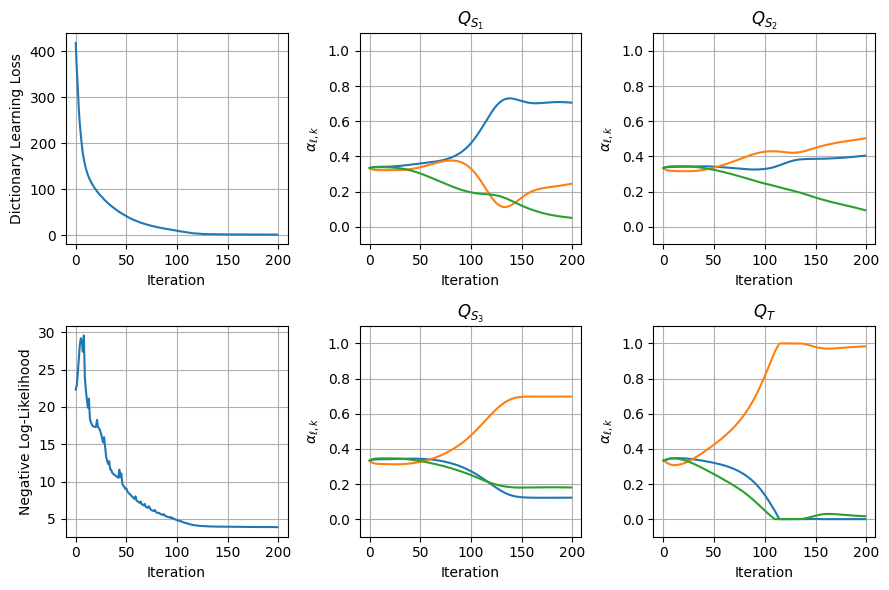

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

axes[0, 0].plot(history['loss'])
axes[0, 0].set_ylabel('Dictionary Learning Loss')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_xticks([0, 50, 100, 150, 200])
axes[0, 0].grid(':')

axes[1, 0].plot(history['nll'])
axes[1, 0].set_ylabel('Negative Log-Likelihood')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_xticks([0, 50, 100, 150, 200])
axes[1, 0].grid(':')

positions = [(0, 1), (0, 2), (1, 1), (1, 2)]
for i in range(3):
    ax = axes[positions[i]]
    for k in range(n_components):
        ax.plot(whist[:, i, k], label='Atom {}'.format(k + 1))
    ax.set_title(r"$Q_{S_{" + str(i + 1) + "}}$")
    ax.set_ylim([-0.1, 1.1])
    ax.set_ylabel(r'$\alpha_{\ell,k}$')
    ax.set_xlabel('Iteration')
    ax.set_xticks([0, 50, 100, 150, 200])
    ax.grid(':')
ax = axes[positions[3]]
for k in range(n_components):
    ax.plot(whist[:, 3, k], label='Atom {}'.format(k + 1))
ax.set_ylim([-0.1, 1.1])
ax.set_title(r"$Q_{T}$")
ax.set_ylabel(r'$\alpha_{\ell,k}$')
ax.set_xlabel('Iteration')
ax.set_xticks([0, 50, 100, 150, 200])
ax.grid(':')
plt.tight_layout()

then we reproduce Fig. 4 (b), 

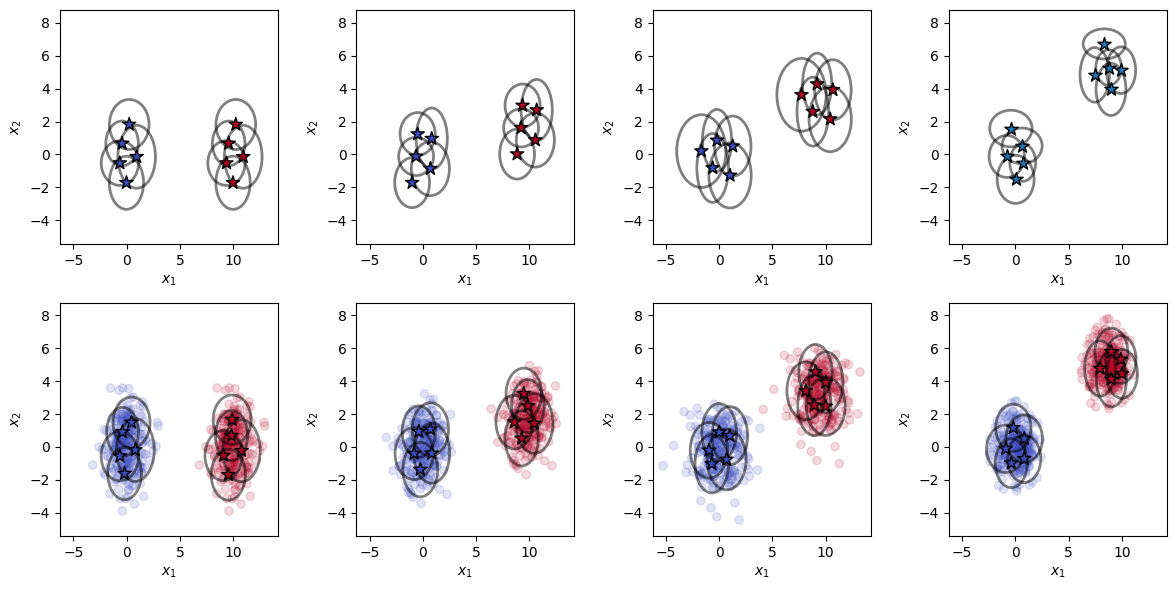

In [35]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for l in range(n_datasets):
    ax = axes[0, l]
    weights, means, variances, labels = gmms[l]
    if labels is not None:
        ax.scatter(means[:, 0],
                   means[:, 1],
                   marker='*',
                   edgecolor='k', s=100, c=labels[:, 1], cmap='coolwarm', zorder=5)
    else:
        ax.scatter(means[:, 0], means[:, 1], marker='*', edgecolor='k', s=100, zorder=5)
    for c, u in zip(means, variances):
        plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax, zorder=1, alpha=0.5)

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

    barycenter_means, barycenter_variances, barycenter_labels = mixture_wasserstein_barycenter(
        source_means=MP.detach(),
        source_variances=VP.detach(),
        source_labels=YP.detach(),
        weights=A[l, :],
        verbose=False,
        inner_verbose=False,
        log=False,
        propagate_labels=True,
        penalize_labels=True)

    ax = axes[1, l]
    ax.scatter(barycenter_means[:, 0],
               barycenter_means[:, 1],
               marker='*', edgecolor='k', s=100,
               c=barycenter_labels[:, 1], cmap='coolwarm', zorder=5)
    ax.scatter(x=true_features[l][::2, 0],
               y=true_features[l][::2, 1],
               c=true_labels[l][::2, 1],
               cmap='coolwarm',
               alpha=0.15, zorder=1)
    for c, u in zip(barycenter_means, barycenter_variances):
        plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax, alpha=0.5)

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

plt.tight_layout()